In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables

Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18605e0d0>,
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent

('2017-08-23',)

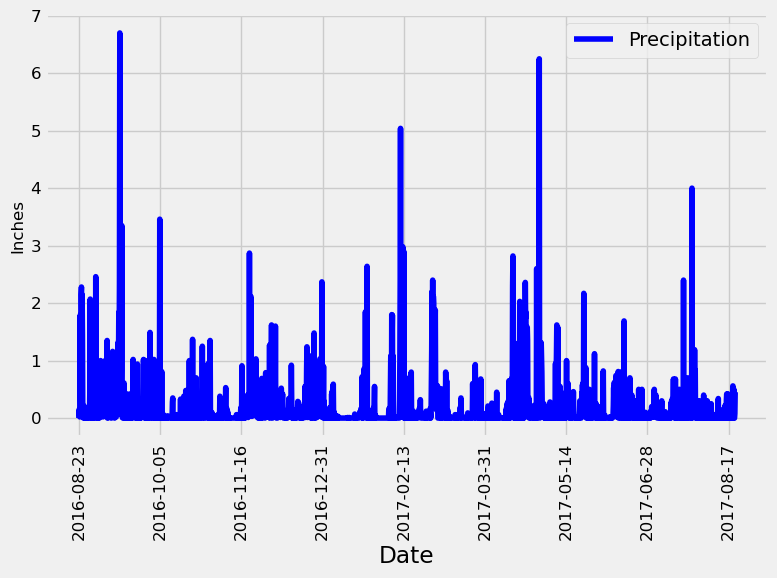

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

prior_yr_precip_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
prior_yr_precip_df = pd.DataFrame(prior_yr_precip_query, columns=['Date', 'Precipitation']).set_index('Date').dropna()
prior_yr_precip_df

# Sort the dataframe by date
prior_yr_precip_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
fontsize = 12
prior_yr_precip_df.plot(color = 'blue', fontsize=fontsize, figsize = (8,6), rot = 90)
plt.ylabel('Inches', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prior_yr_precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).count()
print(station_count)

9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query ('USC00519281'), calculate the lowest, highest, 
#and average temperature.
most_active_station_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281' ).all()
most_active_station_temps

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Using the most active station id ('USC00519281')
# Query the last 12 months of temperature observation data for this station and (cont.)...
most_active_station_py = (session.query(Measurement.station, Measurement.tobs)
             .filter(Measurement.date >= last_year)
             .filter(Measurement.station == 'USC00519281')
             .all())

most_active_station_py_df = pd.DataFrame(most_active_station_py)

#check retrieved data
most_active_station_py_df.head()


,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


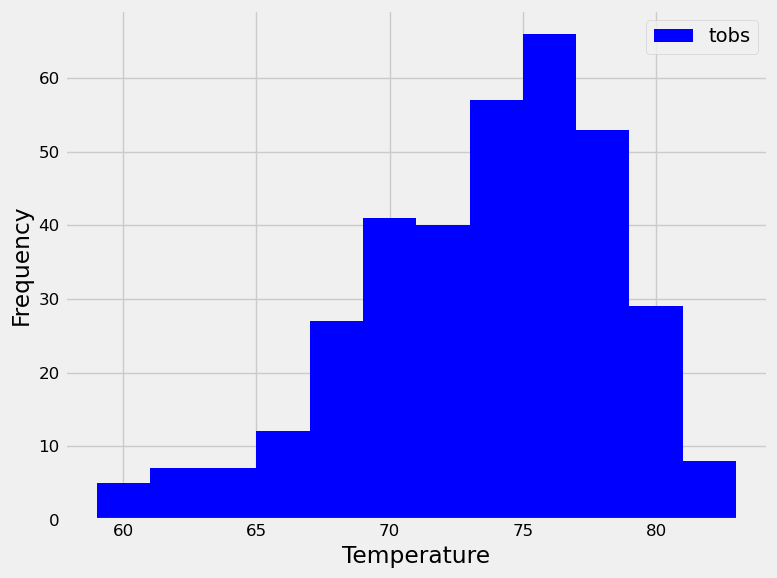

In [18]:
#...plot the results as a histogram
most_active_station_py_df.plot.hist(figsize = (8,6), fontsize=12, color = 'blue', bins=12, legend=True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()